# Install Transformers Library

In [1]:
#!pip install transformers
#!pip install openpyxl
# import glob
# paths = glob.glob('../input/sentiment-classification-on-movie-reviews/*')
# print(paths)
!pip install bert-extractive-summarizer

In [2]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup #BertTokenizer, BertForSequenceClassification
import torch
import pandas as pd
import numpy as np
import time
import datetime
import random
import plotly.express as px
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import re #用以同時刪除多種不同字元

from summarizer import Summarizer
#from transformers import *

# Load Dataset

In [3]:
df = pd.read_csv("../input/sentiment-classification-on-movie-reviews/train.csv")
print(df.head())
print(df.tail())
# print(df.sample(10))

      ID                                             review  sentiment
0  41411  I watched this film because I'm a big fan of R...          0
1  37586  It does not seem that this movie managed to pl...          1
2   6017        Enough is not a bad movie , just mediocre .          0
3  44656  my friend and i rented this one a few nights a...          0
4  38711  Just about everything in this movie is wrong, ...          0
          ID                                             review  sentiment
29336   8019  It 's one of the most honest films ever made a...          1
29337    453  An absorbing and unsettling psychological drama .          1
29338  13097  Soylent Green IS...a really good movie, actual...          1
29339  26896  There just isn't enough here. There a few funn...          0
29340  27094  This show was absolutely terrible. For one Geo...          0


In [4]:
# Get the lists of sentences and their labels.
sentences = df.review.values
labels = df.sentiment.values

In [5]:
# check class distribution
df.sentiment.value_counts(normalize = True)

1    0.509662
0    0.490338
Name: sentiment, dtype: float64

In [6]:
#print(train_inputs.device)
if torch.cuda.is_available():
    print ("yes")
else:
    print("no")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

yes


# 將sentence轉成token

1. 句子前處理

In [7]:
for i in range(0,29341):
    sentences[i] = re.sub('<br />', ' ', sentences[i]) #去除特定字元符號
    sentences[i] = re.sub('--(-+)', '--', sentences[i])
    #sentences[i] = re.sub('\((2([0-9][0-9][0-9])|1([0-9][0-9][0-9]))\)', ' ', sentences[i])
    sentences[i] = re.sub('\?\?(\?+)', '??', sentences[i])
    sentences[i] = re.sub('!!(!+)', '!!', sentences[i])
    
    sentences[i] = re.sub('I\'m', 'I am', sentences[i])
    sentences[i] = re.sub('can\'t', 'can not', sentences[i])
    sentences[i] = re.sub('n\'t', ' not', sentences[i])
    
    if( i % 10000 == 0 ):
        print(i)

0
10000
20000


<AxesSubplot:>

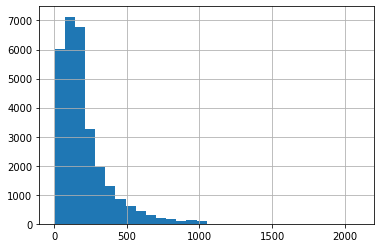

In [8]:
# get length of all the messages
seq_len = [len(i.split()) for i in sentences]

pd.Series(seq_len).hist(bins = 30)

In [9]:
counter_t = 0
for i in range(0,29341):
    if(len(sentences[i].split())>1100): # 句子長度超過1100字的  
        counter_t += 1
        print(i, ":", len(sentences[i].split()))
        #print(i)
print("Total:", counter_t)

993 : 1319
1927 : 1727
2207 : 1833
3989 : 1145
8162 : 1171
15635 : 1106
20712 : 2098
21227 : 1158
23964 : 1144
29108 : 1149
Total: 10


In [10]:
# from summarizer import Summarizer

# model = Summarizer(
# #     custom_model=custom_model,
# #     custom_tokenizer=custom_tokenizer,
# #     sentence_handler = SentenceHandler(language=Chinese),
# )

In [11]:
# result = model(
#     body = sentences[20712], # The string body that you want to summarize (str)
#     #ratio = 0.2, # The ratio of sentences that you want for the final summary (float)
#     min_length = 40, # Parameter to specify to remove sentences that are less than 40 characters (int)
#     #max_length = , # Parameter to specify to remove sentences greater than the max length (int)
#     num_sentences = 8, # Number of sentences to use. Overrides ratio if supplied.
# )
# print(result)
# print(len(result.split()))

In [12]:
# for i in range(0,29341):
#     if(len(sentences[i].split())>250): # 句子長度超過250字的  
#         sentences_temp = model( sentences[i] )
#         sentences[i] = sentences_temp
#     if(i%200 == 0):
#         print(i)

In [13]:
# for i in range(0,29341): # 句子長度超過250字的，取最前段的250字    
#     if(len(sentences[i].split())>250):
#         sentences_temp = sentences[i].split()
#         sentences[i] = " ".join(sentences_temp[0:250])

In [14]:
# counter = 0
# for i in range(0,29341):
#     if(len(sentences[i].split())>=280):
#         counter += 1
#         #print(len(sentences[i].split()))
# print(counter)

2. Tokenize Dataset

In [15]:
## 載入Roberta tokenizer
from transformers import RobertaTokenizerFast
print('==== Loading RobertaTokenizerFast ====\n')
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

==== Loading RobertaTokenizerFast ====



Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [16]:
input_ids = []
idx_counter = 0
for sent in sentences:
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]' 
    )
    input_ids.append(encoded_sent)
    if(idx_counter%5000 == 0):
        print(idx_counter)
    idx_counter += 1
    
print('==== Tokenized Sentences ====\n')  
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


0
5000
10000
15000
20000
25000
==== Tokenized Sentences ====

Original:  I watched this film because I am a big fan of River Phoenix and Joaquin Phoenix. I thought I would give their sister a try, Rain Phoenix. I regret checking it out. She was embarrasing and the film just has this weird plot if thats what you want to call it. Sissy was just weird and Jellybean just sits on a toilet who both sleep with this old man in the mountains, whats going on? I have never been so unsatisfied in my life. It was just total rubbish. I can not believe that the actors agreed to do such a waste of film, money, time and space. Have Sissy being 'beautiful' didnt get to me. I thought she was everything but that. Those thumbs were just stupid, and why do we care if she can hitchhike? WHATS THE POINT?? 0 out of 10, shame the poll doesnt have a 0, doesnt even deserve a 1. Hopefully, Rain is better in other films, I forgive her for this one performance, I mean I wouldnt do much better with that film.
Token I

<AxesSubplot:>

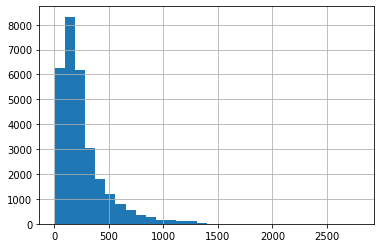

In [17]:
# get length of all the Tokenized Sentences
tokenized_seq_len = [len(i) for i in input_ids]

pd.Series(tokenized_seq_len).hist(bins = 30)

In [18]:
# for i in input_ids:
#     if(len(i)>400):
#         print(len(i))

In [19]:
# Tokenized Sentences長度超過350字的，取最前段的350字
for i in range(0,29341):
    if(len(input_ids[i])>350):
        temp = input_ids[i][0:349]
        temp.append(2) # BERT:102 RoBERTa:2
        input_ids[i] = temp

<AxesSubplot:>

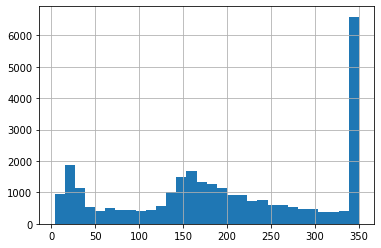

In [20]:
# get length of all the processed encode Sentences
seq_len_encode = [len(i) for i in input_ids]

pd.Series(seq_len_encode).hist(bins = 30)

In [21]:
max_seq_len = max([len(sen) for sen in input_ids])
print('Max sentence length: ', max_seq_len)

Max sentence length:  350


In [22]:
# for i in range(0,29341):
#     if(len(input_ids[i])== 506):
#     #if(len(input_ids[i])>508 and len(input_ids[i])<510):
#         print(i,': encoded len:',len(input_ids[i]),'sentence len:',len(sentences[i].split()))
#         print(sentences[i])

3. Padding

In [23]:
MAX_LEN = max_seq_len
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('Done.')


Padding/truncating all sentences to 350 values...

Padding token: "<pad>", ID: 1
Done.


4. Attention Mask

In [24]:
# attention masks
attention_masks = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

# Split train dataset into train, validation and test sets

In [25]:
## 準備訓練集、驗證集 
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
                input_ids, labels, random_state = 1680, 
                test_size=0.2,
                stratify=labels,
                )

# 同樣masks
train_masks, validation_masks, _, _ = train_test_split(
                attention_masks, labels, random_state = 1680,
                test_size=0.2,
                stratify=labels,
                )

In [26]:
# 轉換成torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [27]:
train_inputs = train_inputs.to(device)
validation_inputs = validation_inputs.to(device)
train_labels = train_labels.to(device)
validation_labels = validation_labels.to(device)
train_masks = train_masks.to(device)
validation_masks = validation_masks.to(device)

In [28]:
# The DataLoader
batch_size = 8

# 建立訓練集的DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# 建立驗證集的DataLoader
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Import RoBERTa-base pretrained model

In [29]:
## Load RobertaForSequenceClassification, the pretrained Roberta model
model = RobertaForSequenceClassification.from_pretrained(
        'siebert/sentiment-roberta-large-english', #'cardiffnlp/twitter-roberta-base-sentiment', # 'roberta-base'
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False,
        )

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [30]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The RoBERTa model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# to cuda
model.to(device)

The RoBERTa model has 393 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 1024)
roberta.embeddings.position_embeddings.weight            (514, 1024)
roberta.embeddings.token_type_embeddings.weight            (1, 1024)
roberta.embeddings.LayerNorm.weight                          (1024,)
roberta.embeddings.LayerNorm.bias                            (1024,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight     (1024, 1024)
roberta.encoder.layer.0.attention.self.query.bias            (1024,)
roberta.encoder.layer.0.attention.self.key.weight       (1024, 1024)
roberta.encoder.layer.0.attention.self.key.bias              (1024,)
roberta.encoder.layer.0.attention.self.value.weight     (1024, 1024)
roberta.encoder.layer.0.attention.self.value.bias            (1024,)
roberta.encoder.layer.0.attention.output.dense.weight   (1024, 1024)
roberta.encoder.layer.0.attention.output.dense.bias        

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [31]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  weight_decay = 0.01,# default is 0.
                )
                
epochs = 3 # authors recommend between 2 and 4
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps = 0, # Default value
                num_training_steps = total_steps
                )

In [32]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [33]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [34]:
seed_val = 64

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [35]:
loss_values = []
accuracy_values = []

# Train Process

In [36]:
# 儲存訓練和評估的 loss、準確率、訓練時長等統計指標, 
training_stats = []

# 統計整個訓練時長
total_t0 = time.time()

# For each Training epoch
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('======== Training ========\n')    
    t0 = time.time()# Measure how long the training epoch takes.    
    total_loss = 0 # Reset the total loss for this epoch.
    
    # 將模型設定為訓練模式。這裡並不是呼叫訓練介面的意思
    # dropout、batchnorm 層在訓練和測試模式下的表現是不同的
    # 啟用 BatchNormalization 和 Dropout
    model.train()
    
    # 訓練集小批量迭代
    for step, batch in enumerate(train_dataloader):
        
        # 每經過N次迭代，就輸出進度資訊
        if step % 200 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
#         b_input_ids = batch[0]#.to(device)
#         b_input_mask = batch[1]#.to(device)
#         b_labels = batch[2]#.to(device)
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 每次計算梯度前，都需要將梯度清 0，因為 pytorch 的梯度是累加的
        model.zero_grad()
        
        # 前向傳播
        # 該函式會根據不同的引數，會返回不同的值。本例中,會返回loss和logits--模型的預測結果
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        # 累加 loss
        total_loss += loss.item()
        #_, predicted = torch.max(outputs.logits, 1)
        #total_accuracy += (predicted == b_labels).sum().item()
        
        # 反向傳播
        loss.backward()
         # 梯度裁剪，避免出現梯度爆炸情況
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # 更新引數
        optimizer.step()
        # 更新學習率
        scheduler.step()
    # 平均訓練誤差   
    avg_train_loss = total_loss / len(train_dataloader)
    #avg_train_accuracy = total_accuracy / len(train_dataloader)
    
    loss_values.append(avg_train_loss)
    #accuracy_values.append(avg_train_accuracy)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    #print("  Average training accuracy: {0:.2f}".format(avg_train_accuracy))
    training_time = format_time(time.time() - t0)
    print("  Training epcoh took: {:}".format(training_time))
    
    # ========================================
    #               Validation
    # ========================================
    
    print("")
    print("======== Running Validation ========")
    t0 = time.time()
    
    # 設定模型為評估模式
    # 不啟用 BatchNormalization 和 Dropout
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
    for batch in validation_dataloader:
#         batch = tuple(t for t in batch)#.to(device)
        # 將輸入資料載入到 gpu 中
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # 評估的時候不需要更新引數、計算梯度
        with torch.no_grad():
            outputs = model(b_input_ids, 
                        token_type_ids = None, 
                        attention_mask = b_input_mask)
        logits = outputs[0]
        # 累加 loss
        eval_loss += loss.item()
        # 將預測結果和 labels 載入到 cpu 中計算
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # 計算準確率
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    
    avg_val_loss = eval_loss / nb_eval_steps # len(validation_dataloader)
    avg_val_accuracy = eval_accuracy/nb_eval_steps
    validation_time = format_time(time.time() - t0)
    print("")
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    # 記錄本次 epoch 的所有統計資訊
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
======== Training ========

  Batch   200  of  2,934.    Elapsed: 0:03:24.
  Batch   400  of  2,934.    Elapsed: 0:06:48.
  Batch   600  of  2,934.    Elapsed: 0:10:11.
  Batch   800  of  2,934.    Elapsed: 0:13:34.
  Batch 1,000  of  2,934.    Elapsed: 0:16:57.
  Batch 1,200  of  2,934.    Elapsed: 0:20:21.
  Batch 1,400  of  2,934.    Elapsed: 0:23:44.
  Batch 1,600  of  2,934.    Elapsed: 0:27:08.
  Batch 1,800  of  2,934.    Elapsed: 0:30:31.
  Batch 2,000  of  2,934.    Elapsed: 0:33:55.
  Batch 2,200  of  2,934.    Elapsed: 0:37:18.
  Batch 2,400  of  2,934.    Elapsed: 0:40:42.
  Batch 2,600  of  2,934.    Elapsed: 0:44:05.
  Batch 2,800  of  2,934.    Elapsed: 0:47:28.

  Average training loss: 0.31
  Training epcoh took: 0:49:44

======== Running Validation ========

  Accuracy: 0.95
  Loss: 0.00
  Validation took: 0:03:56

======== Epoch 2 / 3 ========
======== Training ========

  Batch   200  of  2,934.    Elapsed: 0:03:23.
  Batch   400  of  

In [37]:
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

# Save weight

In [38]:
torch.save(model, './model.pth')

In [39]:
# 保存訓練好的權重
torch.save(model.state_dict(), './model_state_dict.pt')

In [40]:
model.save_pretrained('./')

In [41]:
# model.load_state_dict(torch.load("save.pt"))  #model.load_state_dict()函数把加载的权重复制到模型的权重中去

# Predict

In [42]:
# Load the dataset into a pandas dataframe.
df_predict = pd.read_csv("../input/sentiment-classification-on-movie-reviews/test.csv")

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_predict.shape[0]))

print(df_predict.head())
print(df_predict.tail())

# Create sentence lists
sentences_predict = df_predict.review.values

Number of test sentences: 29,341

      ID                                             review
0  22622  Robert Lansing plays a scientist experimenting...
1  10162  Well I've enjoy this movie, even though someti...
2  17468  First things first - though I believe Joel Sch...
3  42579  I watched this movie on the grounds that Amber...
4    701  A certain sexiness underlines even the dullest...
          ID                                             review
29336  30370  It is difficult to rate a writer/director's fi...
29337  18654  After watching this movie once, it quickly bec...
29338  47985  Even though i sat and watched the whole thing,...
29339   9866  Warning Spoilers following. Superb recreation ...
29340  35559  My, my, my: Peter Cushing and Donald Pleasance...


In [62]:
# 去除特定字元符號
for i in range(0,29341):
    sentences_predict[i] = re.sub('<br />', ' ', sentences_predict[i])
    sentences_predict[i] = re.sub('--(-+)', '--', sentences_predict[i])
    #sentences_predict[i] = re.sub('\((2([0-9][0-9][0-9])|1([0-9][0-9][0-9]))\)', ' ', sentences_predict[i])
    sentences_predict[i] = re.sub('\?\?(\?+)', '??', sentences_predict[i])
    sentences_predict[i] = re.sub('!!(!+)', '!!', sentences_predict[i])
    
    sentences_predict[i] = re.sub('I\'m', 'I am', sentences_predict[i])
    sentences_predict[i] = re.sub('can\'t', 'can not', sentences_predict[i])
    sentences_predict[i] = re.sub('n\'t', ' not', sentences_predict[i])
    if( i % 10000 == 0 ):
        print(i)

0
10000
20000


In [44]:
# for i in range(0,29341): # 句子長度超過270字的，取最前段的270字    
#     if(len(sentences_predict[i].split())>270):
#         sentences_temp = sentences_predict[i].split()
#         sentences_predict[i] = " ".join(sentences_temp[0:270])

In [63]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_predict = []
idx_counter = 0
# For every sentence...
for sent in sentences_predict:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids_predict.append(encoded_sent)
    if(idx_counter%5000 == 0):
        print(idx_counter)
    idx_counter += 1

0
5000
10000
15000
20000
25000


In [64]:
# Tokenized Sentences長度超過350字的，取最前段的350字
for i in range(0,29341):
    if(len(input_ids_predict[i])>350):
        temp = input_ids_predict[i][0:349]
        temp.append(2)
        input_ids_predict[i] = temp

In [65]:
max_seq_len_predict = max([len(sen) for sen in input_ids_predict])
print('Max sentence length: ', max_seq_len_predict)

Max sentence length:  350


<AxesSubplot:>

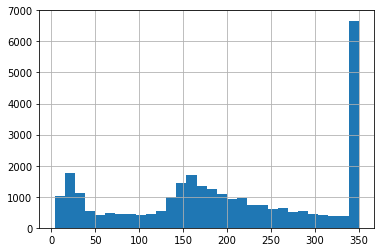

In [66]:
# get length of all the encode
seq_len_predict_encode = [len(i) for i in input_ids_predict]

pd.Series(seq_len_predict_encode).hist(bins = 30)

In [49]:
# for i in range(0,29341):
#     if(len(input_ids_predict[i])==500):
#         print(i,': encoded len:',len(input_ids_predict[i]),'sentence len:',len(sentences_predict[i].split()))
#         print(sentences_predict[i])

In [67]:
MAX_LEN_predict = max_seq_len_predict

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN_predict)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens
input_ids_predict = pad_sequences(input_ids_predict, maxlen=MAX_LEN_predict, 
                          dtype="long", truncating="post", padding="post")
print('Padding done.')

# Create attention masks
attention_masks_predict = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_predict:
    seq_mask = [float(i>0) for i in seq]
    attention_masks_predict.append(seq_mask)

print('Create attention masks done.')


Padding/truncating all sentences to 350 values...

Padding token: "<pad>", ID: 1
Padding done.
Create attention masks done.


In [68]:
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids_predict).to(device)
prediction_masks = torch.tensor(attention_masks_predict).to(device)
# prediction_labels = torch.tensor(labels_predict)

# Set the batch size.  
batch_size = 8 

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks)#, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [69]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
pred , true_labels = [], []

counter_predict = 0
        
# Predict 
for batch in prediction_dataloader:
    
    if counter_predict % 200 == 0:
        print('{:>5,}  of  {:>5,}. '.format(counter_predict, len(prediction_dataloader)) )
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    #b_input_ids, b_input_mask, b_labels = batch
    b_input_ids, b_input_mask = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
#     label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    pred.append(logits)
    #true_labels.append(label_ids)
    counter_predict += 1

print('DONE.')

Predicting labels for 29,341 test sentences...
    0  of  3,668. 
  200  of  3,668. 
  400  of  3,668. 
  600  of  3,668. 
  800  of  3,668. 
1,000  of  3,668. 
1,200  of  3,668. 
1,400  of  3,668. 
1,600  of  3,668. 
1,800  of  3,668. 
2,000  of  3,668. 
2,200  of  3,668. 
2,400  of  3,668. 
2,600  of  3,668. 
2,800  of  3,668. 
3,000  of  3,668. 
3,200  of  3,668. 
3,400  of  3,668. 
3,600  of  3,668. 
DONE.


In [53]:
# import numpy as np
# pred = [[1,4],[2,8]]

In [54]:
# preds = np.concatenate(pred)

In [55]:
# print(preds)

In [56]:
# labels = np.argmax(preds, axis =1)

In [70]:
# deal with predict result
pred_flat = []
for i in range( 0, len(prediction_dataloader) ):
    pred_flat.append( np.argmax(pred[i], axis=1).flatten() ) # 沿著行(axis=0)或列(axis=1)查詢最大值的索引號

pred_list = []
for i in pred_flat:
    for j in i:
        pred_list.append(j)
# Convert List to numpy Arrays
predictions = np.array(pred_list)

In [71]:
print(pred_flat[0:2])
print(predictions[0:32])
print(len(predictions))

[array([0, 1, 0, 0, 1, 0, 1, 1]), array([0, 0, 1, 0, 0, 0, 1, 1])]
[0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0]
29341


In [72]:
# write predict result to file
ID_predict = df_predict.ID.values

results = pd.DataFrame({"ID":ID_predict,
                        "sentiment":predictions})

results.to_csv(f'/kaggle/working/results.csv',index=False)

In [73]:
results.describe()

,ID,sentiment
count,29341.000000,29341.000000
mean,29332.588903,0.516342
std,16878.341879,0.499741
min,0.000000,0.000000
25%,14759.000000,0.000000
50%,29332.000000,1.000000
75%,43859.000000,1.000000
max,58679.000000,1.000000


In [74]:
# check class distribution
results.sentiment.value_counts(normalize = True)

1    0.516342
0    0.483658
Name: sentiment, dtype: float64